In [32]:
# 📘 Análisis Educación y Pobreza (UNICEF + World Bank)
### Autora: **Deysi Gálvez**
#Proyecto Final — Ironhack Data Analytics Bootcamp


In [33]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt


In [34]:
file_path = r"C:\Deysi\ironHack\ironHack\projects\Educacion\data\Datos_de_asistencia_escolar.csv"

unicef_df = pd.read_csv(file_path)

# Limpieza básica
unicef_df["year"] = pd.to_numeric(unicef_df["year"], errors="coerce")
unicef_df["school_attendance"] = pd.to_numeric(unicef_df["school_attendance"], errors="coerce")
unicef_df["country_code"] = unicef_df["country_code"].str.strip().str.upper()

unicef_df.dropna(subset=["year", "school_attendance"], inplace=True)

unicef_df.head()

,Unnamed: 0,country_code,country_name,school_attendance,year
0,41,AFG,Afghanistan,34.136059,2015
1,43,DZA,Algeria,78.145416,2020
2,45,AGO,Angola,52.865299,2016
3,48,ARG,Argentina,84.045921,2020
4,49,ARM,Armenia,61.500000,2016


In [35]:
top30 = (
    unicef_df.sort_values("school_attendance")
    .groupby("country_code")
    .first()
    .reset_index()
    .nsmallest(30, "school_attendance")
)

top30[["country_name", "country_code", "school_attendance"]]


,country_name,country_code,school_attendance
112,United Republic of Tanzania,TZA,3.100000
71,Mozambique,MOZ,3.400000
75,Niger,NER,3.900000
97,South Sudan,SSD,4.500000
8,Burkina Faso,BFA,4.600000
18,Central African Republic,CAF,5.363203
102,Chad,TCD,6.660535
41,Guinea-Bissau,GNB,6.864424
113,Uganda,UGA,7.800000
35,Ethiopia,ETH,7.924213


In [36]:
import time

indicators = {
    "SI.POV.DDAY": "Pobreza extrema ($2.15/día)",
    "SI.POV.LMIC": "Pobreza moderada ($3.65/día)",
    "SI.POV.UMIC": "Pobreza alta ($5.50/día)",
    "SI.POV.NAHC": "Pobreza nacional"
}

country_codes = top30["country_code"].unique().tolist()
codes_str = ";".join(country_codes)

best_indicator = None
best_df = None
max_rows = 0

print("🔍 Probando indicadores para encontrar el que más datos tenga...\n")

for code, desc in indicators.items():

    url = f"https://api.worldbank.org/v2/country/{codes_str}/indicator/{code}?format=json&date=2000:2022&per_page=20000"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"❌ Error con: {code}")
        continue

    data = response.json()
    if len(data) < 2 or data[1] is None:
        print(f"⚠ No hay datos para: {code}")
        continue

    df = pd.DataFrame(data[1])[["country", "date", "value"]]
    df["country_name"] = df["country"].apply(lambda x: x["value"])
    df["country_code"] = df["country"].apply(lambda x: x["id"])
    df.rename(columns={"value": "poverty_rate", "date": "year"}, inplace=True)
    df["year"] = pd.to_numeric(df["year"], errors="coerce")

    df.dropna(subset=["poverty_rate", "year"], inplace=True)

    print(f"✔ {code} ({desc}) → {df.shape[0]} filas")

    if df.shape[0] > max_rows:
        best_indicator = code
        best_df = df
        max_rows = df.shape[0]

print("\n🎯 Indicador con más información disponible:", best_indicator)
best_df.head()

🔍 Probando indicadores para encontrar el que más datos tenga...

✔ SI.POV.DDAY (Pobreza extrema ($2.15/día)) → 116 filas
✔ SI.POV.LMIC (Pobreza moderada ($3.65/día)) → 116 filas
✔ SI.POV.UMIC (Pobreza alta ($5.50/día)) → 116 filas
✔ SI.POV.NAHC (Pobreza nacional) → 116 filas

🎯 Indicador con más información disponible: SI.POV.DDAY


,country,year,poverty_rate,country_name,country_code
2,"{'id': 'BI', 'value': 'Burundi'}",2020,74.2,Burundi,BI
9,"{'id': 'BI', 'value': 'Burundi'}",2013,75.8,Burundi,BI
16,"{'id': 'BI', 'value': 'Burundi'}",2006,81.5,Burundi,BI
24,"{'id': 'BJ', 'value': 'Benin'}",2021,27.2,Benin,BJ
27,"{'id': 'BJ', 'value': 'Benin'}",2018,37.2,Benin,BJ


In [37]:
from country_converter import CountryConverter
cc = CountryConverter()

# Convertir país ISO2 → ISO3
best_df['country_code'] = best_df['country_code'].str.upper()
best_df['country_code'] = cc.convert(best_df['country_code'], src='ISO2', to='ISO3')

# MERGE ahora sí funcionará
merged = pd.merge(
    best_df,
    unicef_df,
    on=['country_code', 'year'],
    how='inner'
)

print("Filas combinadas:", merged.shape[0])
print("Países combinados:", merged['country_code'].nunique())


Filas combinadas: 17
Países combinados: 5


In [38]:
corr = merged[["poverty_rate", "school_attendance"]].corr().iloc[0, 1]
corr


-0.05024296671931309

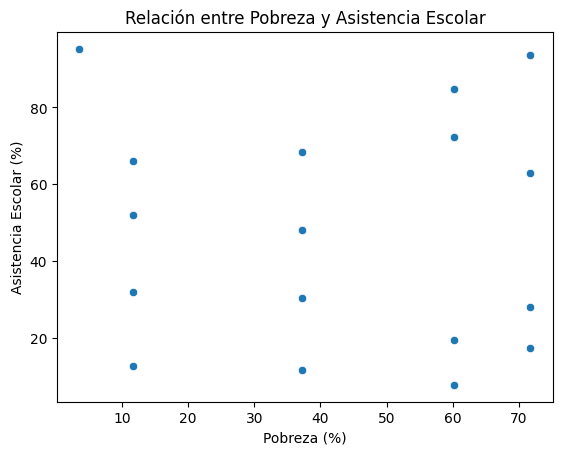

In [39]:
sns.scatterplot(
    data=merged,
    x="poverty_rate",
    y="school_attendance"
)
plt.title("Relación entre Pobreza y Asistencia Escolar")
plt.xlabel("Pobreza (%)")
plt.ylabel("Asistencia Escolar (%)")
plt.show()


In [40]:
merged.head()


,country,year,poverty_rate,country_name_x,country_code,Unnamed: 0,country_name_y,school_attendance
0,"{'id': 'BJ', 'value': 'Benin'}",2018,37.2,Benin,BEN,60,Benin,48.099998
1,"{'id': 'BJ', 'value': 'Benin'}",2018,37.2,Benin,BEN,298,Benin,68.300003
2,"{'id': 'BJ', 'value': 'Benin'}",2018,37.2,Benin,BEN,536,Benin,30.400000
3,"{'id': 'BJ', 'value': 'Benin'}",2018,37.2,Benin,BEN,774,Benin,11.800000
4,"{'id': 'BT', 'value': 'Bhutan'}",2012,3.6,Bhutan,BTN,299,Bhutan,95.199997


In [41]:
# Elegir el nombre del Banco Mundial (x), si no existe usar UNICEF (y)
if "country_name_x" in merged.columns:
    merged.rename(columns={"country_name_x": "country_name"}, inplace=True)
elif "country_name_y" in merged.columns:
    merged.rename(columns={"country_name_y": "country_name"}, inplace=True)



In [42]:
merged.drop(columns=["country_name_y"], inplace=True, errors="ignore")


In [43]:
ranking = (
    merged.groupby("country_name")["school_attendance"]
    .mean()
    .sort_values()
)

print(ranking.head(15))


country_name
Benin     39.650000
Guinea    40.678555
Uganda    46.079356
Malawi    50.483912
Bhutan    95.199997
Name: school_attendance, dtype: float64


In [44]:
output_path = r"C:\Deysi\ironHack\ironHack\projects\Educacion\data\merged_unicef_worldbank.csv"

merged.to_csv(output_path, index=False)

output_path


'C:\\Deysi\\ironHack\\ironHack\\projects\\Educacion\\data\\merged_unicef_worldbank.csv'